In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.integrate as si
import seaborn as sns

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel as C 
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import DotProduct as DotP
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings("ignore")

# GPR dos dados de $d_{L}$ para n=40 aglomerados

In [2]:
GMF = pd.read_csv('GMF.csv')

In [3]:
DADOS_RIESS = pd.read_csv("RIESS_PRIORS.csv")
DADOS_RIESS.head()

,redshift,dL_riess,erro_riess
0,0.50349,2782.754789,21.118462
1,0.49520,2789.439791,19.538049
2,0.67820,4447.002232,38.233709
3,0.86720,5004.212934,38.348295
4,0.79920,4924.703680,39.610930


In [4]:
DADOS_PLANCK = pd.read_csv("PLANCK_PRIORS.csv")
DADOS_PLANCK.head()

,redshift,dL_planck,erro_planck
0,0.50349,3051.229951,21.468927
1,0.49520,3058.559911,19.758393
2,0.67820,4876.040986,39.470748
3,0.86720,5487.010371,39.521318
4,0.79920,5399.830208,40.873809


In [5]:
redshift = np.array(DADOS_RIESS['redshift'])

DL_RIESS = np.array(DADOS_RIESS['dL_riess'])
DL_PLANCK = np.array(DADOS_PLANCK['dL_planck'])

DL_ERRO_RIESS = np.array(DADOS_RIESS['erro_riess'])
DL_ERRO_PLANCK = np.array(DADOS_PLANCK['erro_planck'])

n = len(DL_RIESS)
d= 1

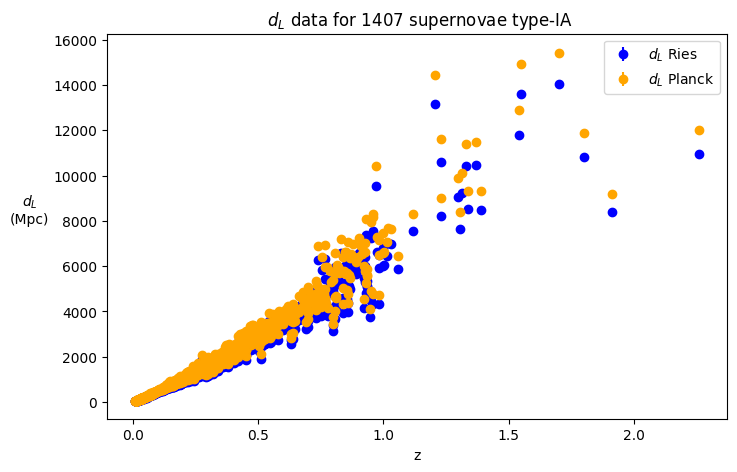

In [6]:
f_x, ax = plt.subplots(1,1, figsize=(8,5))
plt.errorbar(redshift, DL_RIESS, yerr=DL_ERRO_RIESS, color='blue', fmt="o", label=r"$d_{L}$ Ries")
plt.errorbar(redshift, DL_PLANCK, yerr=DL_ERRO_PLANCK, color='orange', fmt="o", label=r"$d_{L}$ Planck")
plt.title(r' $d_{L}$ data for 1407 supernovae type-IA')
plt.xlabel(r'z')
plt.ylabel(r'$d_{L}\,$' +'\n'+'(Mpc)', rotation = 0, labelpad= 17)
plt.legend()

In [7]:
# As variáveis para o processo Gaussiano
X = redshift.reshape(n,d)
Y_RIESS =DL_RIESS
Y_PLANCK = DL_PLANCK

X_star = np.array(GMF['Redshift'])
X_star = X_star.reshape(40,1)

len(Y_PLANCK)

1047

### random seaarch para os hiperparâmetros do modelo

In [8]:
def random_search(x, y, n):
    best_score = -np.inf
    best_params = None

    for _ in range(n):
        
        s1 = np.random.uniform(0.1, 500)
        constant_value_1= np.random.uniform(0.001,500)
        l = np.random.uniform(0.001, 500)

        kernel = DotP( s1)+C(constant_value=constant_value_1)*RBF(length_scale=l)
        model = GaussianProcessRegressor(kernel=kernel, alpha=5e5)

        model.fit(x, y)

        score = model.score(x, y)

        if score > best_score:
            best_score = score
            best_params = {'s1': s1, 'C1':constant_value_1, 'l':l}
                          
                           
    return best_params, best_score

In [9]:
# Número de iterações da busca aleatória
n_int = 100

In [10]:
best_params_RIESS, best_score_RIESS = random_search(X, Y_RIESS, n_int)

print("Melhores parâmetros encontrados:")
print(best_params_RIESS)
print("Best score:")
print(best_score_RIESS)

Melhores parâmetros encontrados:
{'s1': 212.43768630536232, 'C1': 257.59428607959404, 'l': 17.040257232849882}
Best score:
0.9406096318039076


In [11]:
best_params_PLANCK, best_score_PLANCK = random_search(X, Y_PLANCK, n_int)

print("Melhores parâmetros encontrados:")
print(best_params_PLANCK)
print("Best score:")
print(best_score_PLANCK)

Melhores parâmetros encontrados:
{'s1': 184.42600733987146, 'C1': 222.9260426956222, 'l': 153.40461727753052}
Best score:
0.9406371901756239


In [12]:
s1_RIESS = best_params_RIESS['s1']
constant1_RIESS=best_params_RIESS['C1']
l_RIESS = best_params_RIESS['l']

s1_PLANCK = best_params_PLANCK['s1']
constant1_PLANCK =best_params_PLANCK['C1']
l_PLANCK = best_params_PLANCK['l']

In [13]:
# Kernel com os melhores valores de C, l e sigma:
GPR_Kernel_RIES =DotP(s1_RIESS)+C(constant1_RIESS)*RBF(l_RIESS )
GPR_Kernel_PLANCK =DotP(s1_PLANCK)+C(constant1_PLANCK)*RBF(l_PLANCK )


GPR_RIESS = GaussianProcessRegressor(kernel=GPR_Kernel_RIES, alpha=5e5)
GPR_PLANCK = GaussianProcessRegressor(kernel=GPR_Kernel_PLANCK, alpha=5e5)

In [14]:
GPR_RIESS.fit(X, Y_RIESS)
GPR_PLANCK.fit(X, Y_PLANCK)

GaussianProcessRegressor(alpha=500000.0,
                         kernel=DotProduct(sigma_0=184) + 14.9**2 * RBF(length_scale=153))

In [15]:
Y_pred_RIESS, std_RIESS = GPR_RIESS.predict(X_star, return_std=True)
Y_pred_PLANCK, std_PLANCK = GPR_PLANCK.predict(X_star, return_std=True)

dL_GPR_RIESS = Y_pred_RIESS
dL_GPR_PLANCK =Y_pred_PLANCK

(0.048, 1.093)

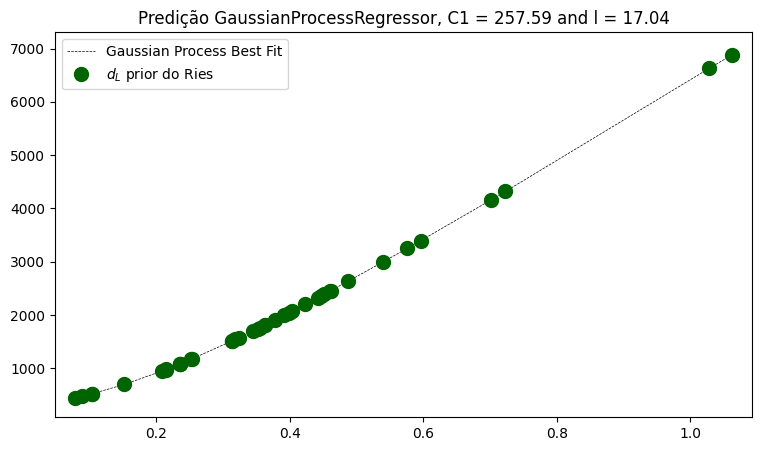

In [16]:
fig, ax = plt.subplots(figsize=(9,5))
plt.errorbar(X_star, dL_GPR_RIESS, yerr=std_RIESS, color='darkgreen',
             label = r'$d_{L}$ prior do Ries', fmt="o", markersize=10)
sns.lineplot(x=np.array(GMF['Redshift']), y=Y_pred_RIESS, color='black', 
             label='Gaussian Process Best Fit', ax=ax, linewidth = 0.5, ls='--')
ax.set(title=f'Predição GaussianProcessRegressor, C1 = {round(constant1_RIESS,2)} and l = {round(l_RIESS,2) }')
ax.legend(loc='upper left')
plt.xlim([X_star.min()-0.03,X_star.max()+0.03])

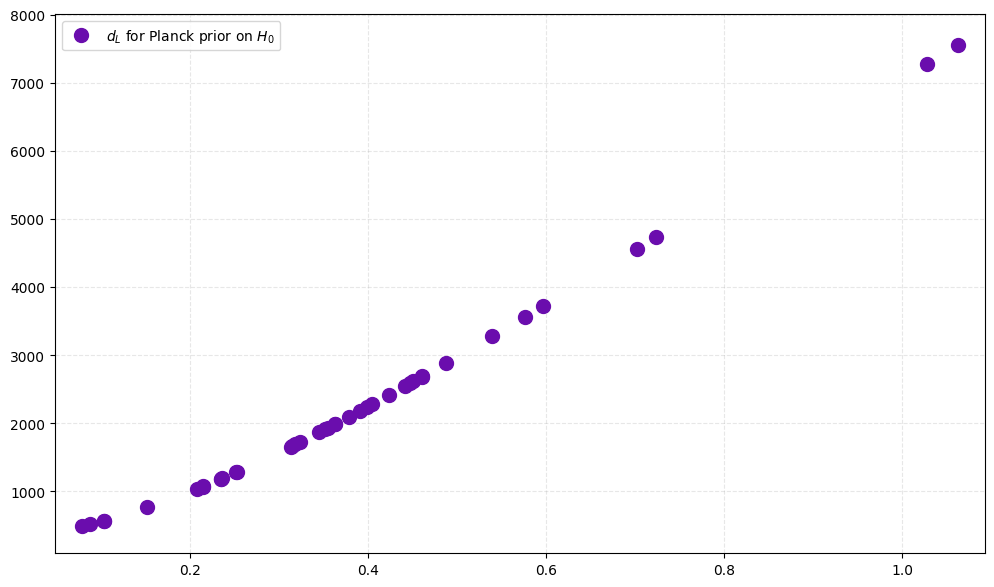

In [27]:
fig, ax = plt.subplots(figsize=(12, 7))
plt.errorbar(
    X_star, dL_GPR_PLANCK, yerr=std_PLANCK, color='#6A0DAD',
    label=r'$d_{L}$ for Planck prior on $H_{0}$', fmt="o", markersize=10
)
plt.grid(linestyle='--', alpha=0.3)
ax.legend(loc='upper left')
plt.xlim([X_star.min() - 0.03, X_star.max() + 0.03])
plt.savefig("dl_planck.png")
plt.show()


In [18]:
data_planck = {'redshift': np.array(GMF['Redshift']), 'dL_Planck':dL_GPR_PLANCK, 'erro_Planck':std_PLANCK}
data_ries = {'redshift': np.array(GMF['Redshift']), 'dL_Riess':dL_GPR_RIESS, 'erro_Riess':std_RIESS}

In [19]:
DL_DATA_PLANCK = pd.DataFrame(data_planck)
DL_DATA_RIESS = pd.DataFrame(data_ries)

DL_DATA_PLANCK.to_csv("DL_DATA_PLANCK.csv", index=False)
DL_DATA_RIESS.to_csv("DL_DATA_RIESS.csv", index=False)

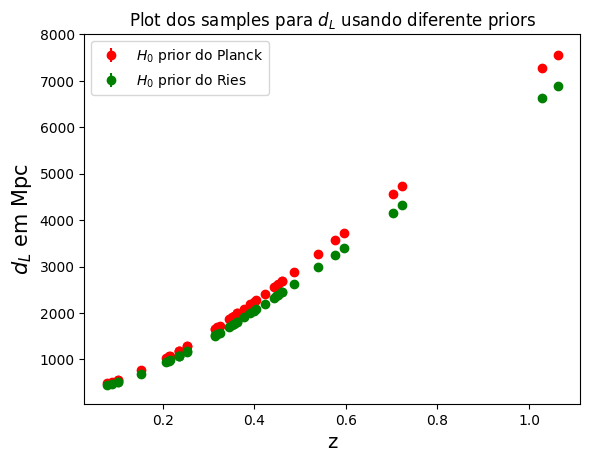

In [20]:
DL_PLANCK  = dL_GPR_PLANCK
DL_RIES = dL_GPR_RIESS

erro_PLANCK =std_PLANCK
erro_RIES = std_RIESS

plt.errorbar(np.array(GMF['Redshift']), DL_PLANCK, yerr = erro_PLANCK, fmt="o", color="r")
plt.errorbar(np.array(GMF['Redshift']), DL_RIES, yerr = erro_RIES, fmt="o", color="g")

plt.title(r'Plot dos samples para $d_{L}$ usando diferente priors')
plt.xlabel('z', size = 14)
plt.ylabel('$d_{L}$ em Mpc', size = 15)
plt.legend(['$H_{0}$ prior do Planck', '$H_{0}$ prior do Ries', 'Cronômetros Cósmicos'], loc='upper left')
plt.show()

In [21]:
DL_DATA_RIESS.head()

,redshift,dL_Riess,erro_Riess
0,0.078,441.227137,33.678052
1,0.088,470.238044,32.403511
2,0.103,517.019595,30.776861
3,0.103,517.019595,30.776861
4,0.152,695.736214,27.676888


In [22]:
DL_DATA_PLANCK.head()

,redshift,dL_Planck,erro_Planck
0,0.078,483.292081,33.692179
1,0.088,515.081562,32.416762
2,0.103,566.366350,30.790298
3,0.103,566.366350,30.790298
4,0.152,762.438273,27.698455
